# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation.
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error.
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

In [1]:
import numpy as np

class PegasosSVM(object):
    def __init__(self, lam, T=10000):
        self.lam = lam
        self.T = T
        self.w = None

    def fit(self, X, Y):
        X_modif = np.hstack([X, np.ones((X.shape[0], 1))])
        #Y_modif = np.where(Y == 0, -1, 1)
        n, m = X_modif.shape
        self.w = np.zeros(m, dtype=float)
        for t in range(1, self.T + 1):
            eta_t = 1 / (self.lam * t)

            i = np.random.randint(0,n)
            x_i, y_i = X_modif[i], Y[i]
            if y_i * np.dot(self.w, x_i) < 1:
                self.w = (1 - eta_t * self.lam) * self.w + eta_t * y_i * x_i
            else:
                self.w *= (1 - eta_t * self.lam)

    def predict(self, X):
        X_modif = np.hstack([X, np.ones((X.shape[0], 1))])
        return np.sign(X_modif @ self.w)

    def decision_function(sefl, X):
        X_modif = np.hstack([X, np.ones((X.shape[0], 1))])
        return np.dot(X_modif, self.w)

    def get_params(self, deep=True):
        return {"lam": self.lam, "T": self.T}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data = load_breast_cancer()
X = data.data
Y = data.target
Y = np.where(Y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

"""
X = np.array([[1, 5, 3], [4, 8, 8], [6, 3, 4], [6, 8, 2], [5, 9, 3], [7, 7, 2], [3, 2, 5], [4, 5, 6], [2, 1, 9], [7, 5, 1]])
Y = np.array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
"""
lam = 4
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', PegasosSVM(lam))
])

pipeline.fit(X_train, y_train)
Y_pred  = pipeline.predict(X_test)
#Y_pred = np.where(Y_pred == -1, 0, 1)
#print(np.sum(Y_pred == y_test) / len(y_test))
print(accuracy_score(Y_pred,y_test))

0.956140350877193


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

"""
native_model = LinearSVC(dual=True)
native_model.fit(X, Y)
Y_pred_native_model = native_model.predict(X)

pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(dual=True, max_iter=10000))
])

pipeline_2.fit(X_train, y_train)
Y_pred_native_model  = pipeline_2.predict(X_test)
#Y_pred_native_model
"""
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

score1 = cross_val_score(LinearSVC(dual=True, max_iter=10000), X_scaled, Y, cv=5, scoring='accuracy')
print(score1)

#Y2 = np.where(Y == 0, -1, 1)
score2 = cross_val_score(pipeline, X, Y, cv=5, scoring='accuracy')
print(score2)

[0.94736842 0.95614035 0.95614035 0.98245614 0.99115044]
[0.92105263 0.93859649 0.96491228 0.96491228 0.95575221]


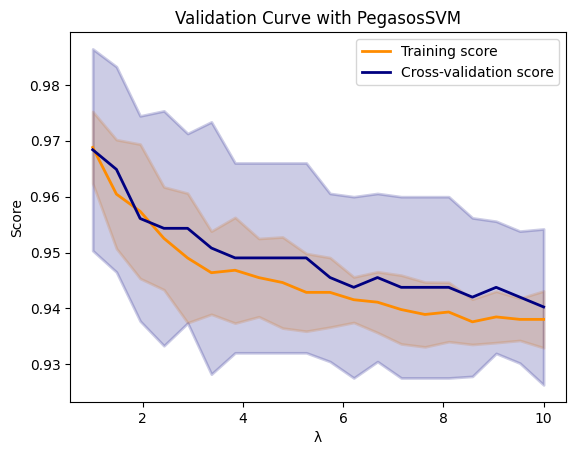

In [5]:
from sklearn.model_selection import validation_curve

lam_range = np.linspace(1, 10, 20)

train_scores, test_scores = validation_curve(
    pipeline, X, Y, param_name="classifier__lam", param_range=lam_range, scoring="accuracy", cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

import matplotlib.pyplot as plt

plt.title("Validation Curve with PegasosSVM")
plt.xlabel("λ")
plt.ylabel("Score")
plt.plot(lam_range, train_scores_mean, label="Training score",
             color="darkorange", lw=2)
plt.fill_between(lam_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(lam_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=2)
plt.fill_between(lam_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()



As λ increases, the accuracy decreases

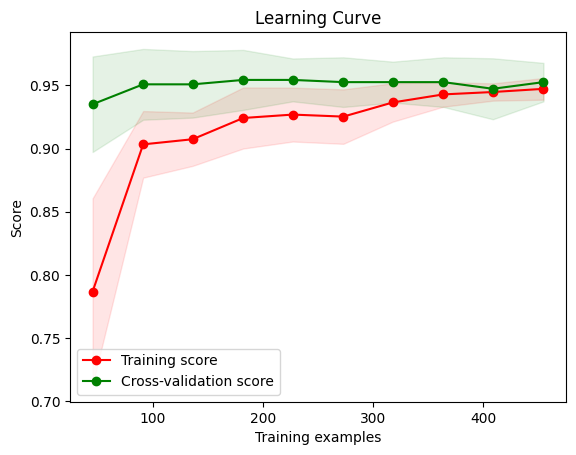

In [6]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

classifier = PegasosSVM(lam)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=Y,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()




As the sample size increases, the accuracy increases to a certain level

## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and
$$
p(y=0) = 0.1
$$.

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

3. repeat the experiment but now set the `class_weight` to be `balanced`.
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.

## Answer #

In [7]:
# a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

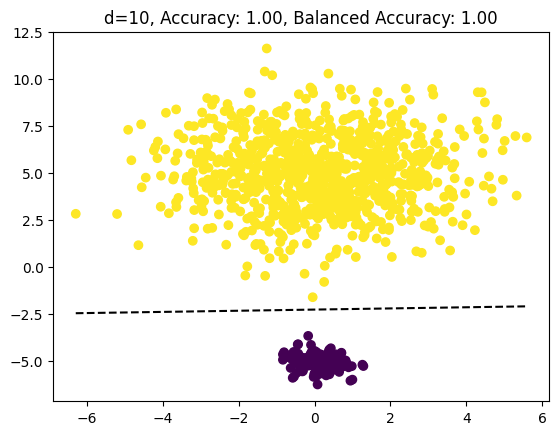

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


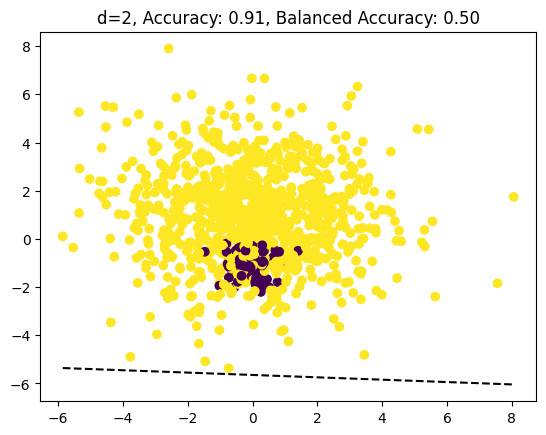

In [8]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def scatterplot(d):
    X, y = make_data(d)
    plt.scatter(X[:,0], X[:,1], c=y)

    model = LinearSVC(dual=True)
    model.fit(X, y)

    coef = model.coef_[0]
    intercept = model.intercept_

    x_hyperplane = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
    y_hyperplane = -(coef[0] * x_hyperplane + intercept) / coef[1]

    acc = accuracy_score(y, model.predict(X))
    bal_acc = balanced_accuracy_score(y, model.predict(X))

    plt.title(f"d={d}, Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}")
    plt.plot(x_hyperplane, y_hyperplane, 'k--')
    plt.show()

scatterplot(10)
scatterplot(2)

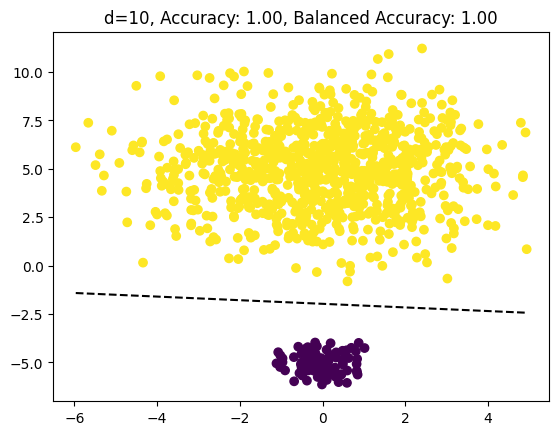

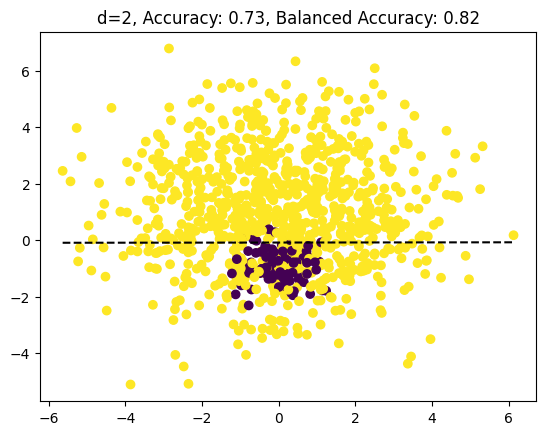

In [9]:
def scatterplot_balanced(d):
    X, y = make_data(d)
    plt.scatter(X[:,0], X[:,1], c=y)

    model = LinearSVC(dual=True, class_weight='balanced')
    model.fit(X, y)

    coef = model.coef_[0]
    intercept = model.intercept_

    x_hyperplane = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
    y_hyperplane = -(coef[0] * x_hyperplane + intercept) / coef[1]

    acc = accuracy_score(y, model.predict(X))
    bal_acc = balanced_accuracy_score(y, model.predict(X))

    plt.title(f"d={d}, Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}")
    plt.plot(x_hyperplane, y_hyperplane, 'k--')
    plt.show()

scatterplot_balanced(10)
scatterplot_balanced(2)

Problem: Class Imbalance
Class Imbalance:
Dr dataset exhibits class imbalance, meaning one class significantly outnumbers the other. This leads to the model tending to classify the predominant class better, while the minority class is often ignored or insufficiently accounted for. As a result, accuracy may be high, but this is primarily due to the correct identification of the predominant class.
Impact on the Hyperplane:

In the case of a linear SVM, such a predominance of one class can lead to the hyperplane being biased towards the minority class. This bias can reduce the overall ability of the model to properly separate the classes, especially in areas where they overlap.

Without Class Weight Balancing: In this scenario, the LinearSVC is likely to have shown a bias towards the more numerous class (in your case, class 1). This happens because the standard SVM aims to minimize overall classification errors, not considering the class imbalance. As a result, the hyperplane would be skewed towards the minority class (class 0), potentially increasing the false negative rate for this class. This is reflected in a low balanced accuracy, as this metric accounts for the representation of each class.

With Class Weight Balancing: By setting the class_weight parameter to 'balanced', LinearSVC automatically adjusts the weights, making the classifier more sensitive to the minority class. This leads to a fairer separation, where the hyperplane takes into account the distribution of both classes more evenly. In this case, an improvement in balanced accuracy is expected, as the model better classifies both classes, even though the overall accuracy might slightly decrease due to an increase in false positives for the dominant class.

Conclusion: The problem with using LinearSVC without considering class balance is that the model may neglect the interests of the smaller class, leading to unfair and potentially impractical classification outcomes, especially in tasks where it's important to accurately identify each class. Using balanced class weights helps to mitigate this bias, making the model more effective in dealing with imbalanced data.

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process.

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

In [10]:
from sklearn.model_selection import GridSearchCV

data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1244)
pipe = Pipeline([('scaler', StandardScaler()),
                ('SVC', LinearSVC(dual = True,max_iter=70000))])
params = {'SVC__multi_class':['ovr', 'crammer_singer'],
          'SVC__loss':['hinge', 'squared_hinge'],
          'SVC__C': np.logspace(-3,3,10)}
gs_LinearSVC = GridSearchCV(pipe,
                      param_grid=params,
                      cv=5, return_train_score=True)
gs_LinearSVC.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %f"
    % (gs_LinearSVC.best_params_, gs_LinearSVC.best_score_)
)
best_LinearSVC = gs_LinearSVC.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The best parameters are {'SVC__C': 0.1, 'SVC__loss': 'hinge', 'SVC__multi_class': 'ovr'} with a score of 0.978022


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
best_LinearSVC.fit(X_train,y_train)
y_pred = best_LinearSVC.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_pred,y_test)
print(f"Accuracy of model with best params: {accuracy}")


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.97      1.00      0.99        76

    accuracy                           0.98       114
   macro avg       0.99      0.97      0.98       114
weighted avg       0.98      0.98      0.98       114

Accuracy of model with best params: 0.9824561403508771


## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data.

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use

* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [12]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

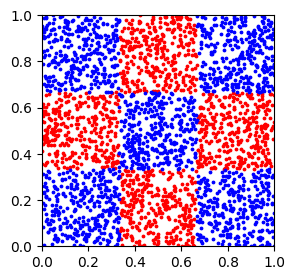

In [13]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [14]:
from sklearn.svm import SVC
param_poly = {
    'kernel': ['poly'],
    'degree': [2, 3, 4, 5],
    'C': [0.1, 1, 10, 100]
}

param_rbf = {
    'kernel': ['rbf'],
    'gamma': [0.1, 1, 10, 100],
    'C': [0.1, 1, 10, 100]
}

grid_search_poly = GridSearchCV(SVC(), param_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X, y)

grid_search_rbf = GridSearchCV(SVC(), param_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X, y)

print("Best params for polynomial kernel:", grid_search_poly.best_params_)
print("Best score for polynomial kernel:", grid_search_poly.best_score_)

print("Best params for RBF kernel:", grid_search_rbf.best_params_)
print("Best score for RBF kernel:", grid_search_rbf.best_score_)

best_poly_model = grid_search_poly.best_estimator_
best_rbf_model = grid_search_rbf.best_estimator_

Best params for polynomial kernel: {'C': 1, 'degree': 5, 'kernel': 'poly'}
Best score for polynomial kernel: 0.6776666666666666
Best params for RBF kernel: {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
Best score for RBF kernel: 0.9909999999999999


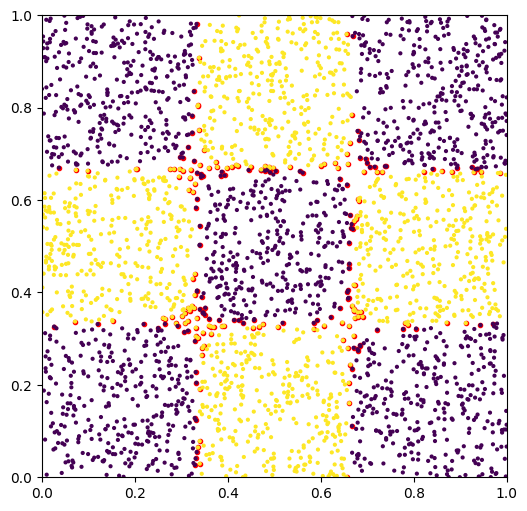

In [19]:
rbf = SVC(kernel='rbf', C=100, gamma=10)
rbf.fit(X, y)
y_pred = rbf.predict(X)
sup_vectors = rbf.support_vectors_
plt.figure(figsize=(6,6))
plt.scatter(sup_vectors[:,0], sup_vectors[:,1], c='red', s=9)
plt.scatter(X[:,0], X[:,1], c=y_pred, s=4)
plt.xlim([0,1])
plt.ylim([0,1]);

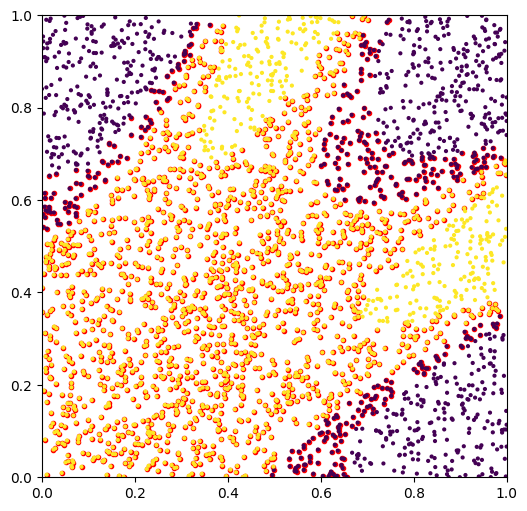

In [18]:
poly = SVC(C=1, degree=5, kernel='poly')
poly.fit(X, y)
y_pred = poly.predict(X)
sup_vectors = poly.support_vectors_
plt.figure(figsize=(6,6))
plt.scatter(sup_vectors[:,0], sup_vectors[:,1], c='red', s=9)
plt.scatter(X[:,0], X[:,1], c=y_pred, s=4)
plt.xlim([0,1])
plt.ylim([0,1]);

Model RBF is better for this case

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

